In [14]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import time

import PulseFinderScipy as pf
import PulseQuantities as pq
import PulseClassification as pc

In [15]:
data_dir = "G:/.shortcut-targets-by-id/11qeqHWCbcKfFYFQgvytKem8rulQCTpj8/crystalize/data/data-202104/041421/Po_4.0g_4.2c_1.1bar_circ_20min_1914/"

In [16]:
# set plotting style
mpl.rcParams['font.size']=20
mpl.rcParams['legend.fontsize']='small'
mpl.rcParams['figure.autolayout']=True
mpl.rcParams['figure.figsize']=[8.0,6.0]

# use for coloring pulses
pulse_class_colors = np.array(['blue', 'green', 'red', 'magenta', 'darkorange'])
pulse_class_labels = np.array(['Other', 'S1-like LXe', 'S1-like gas', 'S2-like', 'Merged S1/S2'])
pc_legend_handles=[]
for class_ind in range(len(pulse_class_labels)):
    pc_legend_handles.append(mpl.patches.Patch(color=pulse_class_colors[class_ind], label=str(class_ind)+": "+pulse_class_labels[class_ind]))

# ==================================================================
# define DAQ and other parameters
#wsize = 12500             # size of event window in samples. 1 sample = 2 ns.
event_window = 25.  # in us
wsize = int(500 * event_window)  # samples per waveform # 12500 for 25 us
vscale = (2000.0/16384.0) # = 0.122 mV/ADCC, vertical scale
tscale = (8.0/4096.0)     # = 0.002 µs/sample, time scale

post_trigger = 0.5 # Was 0.2 for data before 11/22/19
trigger_time_us = event_window*(1-post_trigger)
trigger_time = int(trigger_time_us/tscale)

n_sipms = 8
n_channels = n_sipms+1 # includes sum

# define top, bottom channels
n_top = int((n_channels-1)/2)
top_channels=np.array(range(n_top),int)
bottom_channels=np.array(range(n_top,2*n_top),int)

# sphe sizes in mV*sample
chA_spe_size = 29.02
chB_spe_size = 30.61
chC_spe_size = 28.87
chD_spe_size = 28.86*1.25 # scale factor (0.7-1.4) empirical as of Dec 9, 2020
chE_spe_size = 30.4
chF_spe_size = 30.44
chG_spe_size = 30.84
chH_spe_size = 30.3*1.8 # scale factor (1.6-2.2) empirical as of Dec 9, 2020
spe_sizes = [chA_spe_size, chB_spe_size, chC_spe_size, chD_spe_size, chE_spe_size, chF_spe_size, chG_spe_size, chH_spe_size]

In [17]:
listrq = np.load(data_dir+'rq.npz')

n_events = listrq['n_events'][()]
n_pulses = listrq['n_pulses']
n_s1 = listrq['n_s1']
n_s2 = listrq['n_s2']
s1_before_s2 = listrq['s1_before_s2']
p_area = listrq['p_area']
p_class = listrq['p_class']
drift_Time = listrq['drift_Time']
drift_Time_AS = listrq['drift_Time_AS']
p_max_height = listrq['p_max_height']
p_min_height = listrq['p_min_height']
p_width = listrq['p_width']
p_afs_2l = listrq['p_afs_2l']
p_afs_50 = listrq['p_afs_50']
p_area_ch = listrq['p_area_ch']
p_area_ch_frac = listrq['p_area_ch_frac']
p_area_top = listrq['p_area_top']
p_area_bottom = listrq['p_area_bottom']
p_tba = listrq['p_tba']
sum_s1_area = listrq['sum_s1_area']
sum_s2_area = listrq['sum_s2_area']

center_top_x = listrq['center_top_x']
center_top_y = listrq['center_top_y']
center_bot_x = listrq['center_bot_x']
center_bot_y = listrq['center_bot_y']

listrq.close()
four_drift_time = np.transpose([drift_Time, drift_Time,drift_Time,drift_Time])
four_drift_time_AS = np.transpose([drift_Time_AS, drift_Time_AS,drift_Time_AS,drift_Time_AS])


In [18]:
n_golden = int(np.sum(drift_Time>0))
print("number of golden events found = {0:d} ({1:g}%)".format(n_golden,n_golden*100./n_events))
n_multi = int(np.sum((drift_Time_AS>0)*(drift_Time<=0)))
print("number of multi S2 events found = {0:d} ({1:g}%)".format(n_multi,n_multi*100./n_events))
p_t_rise = tscale*(p_afs_50-p_afs_2l)

# Define some standard cuts for plotting
b_up_down = -0.74 #TBA value to seperate the Po up going and downgoing S1s. 
cut_dict = {}
cut_dict['ValidPulse'] = p_area > 0
cut_dict['PulseClass0'] = p_class == 0
cut_dict['S1'] = (p_class == 1) + (p_class == 2)
cut_dict['S2'] = (p_class == 3) + (p_class == 4)
cut_dict['Co_peak'] = (p_area>30)*(p_area<60)
cut_dict['multi_S2s'] = (four_drift_time<=0)*(four_drift_time_AS>0)
cut_dict['Po_down'] = (p_area>1000)*(p_area<4000)*(p_tba>-1.)*(p_tba<b_up_down)
cut_dict['Po_up'] = (p_area>1500)*(p_area<5000)*(p_tba>b_up_down)*(p_tba<-.15)
cut_dict['Po_all'] = (p_area>1500)*(p_area<5000)*(p_tba<-.15)
SS_cut = drift_Time > 0

# Pick which cut from cut_dict to apply here and whether to save plots
save_pulse_plots=True # One entry per pulse
save_S1S2_plots=True # One entry per S1 (S2) pulse
save_event_plots=True # One entry per event
pulse_cut_name = 'ValidPulse'#'Co_peak'
pulse_cut = cut_dict[pulse_cut_name]
print("number of pulses found passing cut "+pulse_cut_name+" = {0:d} ({1:g}% of pulses found)".format(np.sum(pulse_cut),np.sum(pulse_cut)*100./np.size(p_area)))
#pulse_cut_name = 'ValidPulse_SS_Evt'
#pulse_cut = pulse_cut*SS_cut[:,np.newaxis] # add second dimension to allow broadcasting

s1_cut = pulse_cut*cut_dict['S1']
cleanS1Area = p_area[s1_cut].flatten()
cleanS1RiseTime = p_t_rise[s1_cut].flatten()
cleanS1AreaChFrac = p_area_ch_frac[s1_cut]
cleanS1TBA = p_tba[s1_cut].flatten()
print("number of S1 pulses found = {0:d} ({1:g}% of pulses found)".format(np.sum(s1_cut),np.sum(s1_cut)*100./np.size(p_area)))

s2_cut = pulse_cut*cut_dict['S2']
cleanS2Area = p_area[s2_cut].flatten()
cleanS2RiseTime = p_t_rise[s2_cut].flatten()
cleanS2AreaChFrac = p_area_ch_frac[s2_cut]
cleanS2TBA = p_tba[s2_cut].flatten()
print("number of S2 pulses found = {0:d} ({1:g}% of pulses found)".format(np.sum(s2_cut),np.sum(s2_cut)*100./np.size(p_area)))

# Quantities for plotting only events with n number of pulses, not just all of them
# May still contain empty pulses
howMany = n_pulses < 1000 # How many pulses you do want
nArea = p_area[howMany,:]
nMax = p_max_height[howMany,:]
nmin = p_min_height[howMany,:]
nWidth = p_width[howMany,:]

na2l = p_afs_2l[howMany]
na50 = p_afs_50[howMany]


# Event level quantities 
event_cut_dict = {}
event_cut_dict["SS"] = drift_Time > 0 
event_cut_dict["MS"] = (n_s1 == 1)*(n_s2 > 1)*s1_before_s2
event_cut_dict["Po"] = (drift_Time>0)*np.any((p_tba<-0.25)*(p_tba>-0.72)*(p_area>1400)*(p_area<3200), axis=1)#np.any((p_tba<-0.85)*(p_tba>-0.91)*(p_area>1500)*(p_area<2700), axis=1) # true if any pulse in event matches these criteria
event_cut_dict["lg_S1"] = (drift_Time>0)*np.any((p_area>1000.)*cut_dict["S1"], axis=1) # true if any S1 has area>1000
event_cut_dict["ht"] = (drift_Time>0)*np.any(p_max_height>50, axis=1)
event_cut_dict["area"] = (sum_s1_area>10**3.0)*(sum_s1_area<10**3.5)*(sum_s2_area<10**5.1)*(sum_s2_area>10**4.6)
event_cut_dict["orange"] = np.any((p_tba<-0.3)*(p_tba>-0.75)*(p_t_rise>0.6)*(p_t_rise<1.7), axis=1)
event_cut_dict["Po_down"] = np.any((p_tba<-0.76)*(p_tba>-1.)*(p_area>1000)*(p_area<4000), axis=1)
event_cut_dict["Po_up"] = np.any((p_tba<-0.15)*(p_tba>-0.73)*(p_area>1500)*(p_area<4000), axis=1)


event_cut_name = "SS"#"lg_S1"
event_cut = event_cut_dict[event_cut_name] 
cleanSumS1 = sum_s1_area[event_cut]
cleanSumS2 = sum_s2_area[event_cut]
cleanDT = drift_Time[event_cut]


clean_drift_time_four = four_drift_time[event_cut]
clean_center_top_x = center_top_x[pulse_cut]
clean_center_top_y = center_top_y[pulse_cut]
clean_center_bot_x = center_bot_x[pulse_cut]
clean_center_bot_y = center_bot_y[pulse_cut]

cleanArea = p_area[pulse_cut]
cleanMax = p_max_height[pulse_cut]
cleanMin = p_min_height[pulse_cut]
cleanWidth = p_width[pulse_cut]
cleanPulseClass = p_class[pulse_cut]

cleanAFS2l = p_afs_2l[pulse_cut]
cleanAFS50 = p_afs_50[pulse_cut]
cleanRiseTime = p_t_rise[pulse_cut]

cleanAreaCh = p_area_ch[pulse_cut] # pulse_cut gets broadcast to the right shape
cleanAreaChFrac = p_area_ch_frac[pulse_cut]
cleanAreaTop = p_area_top[pulse_cut]
cleanAreaBottom = p_area_bottom[pulse_cut]
cleanTBA = p_tba[pulse_cut]
# Note: TBA can be <-1 or >+1 if one of top or bottom areas is <0 (can still be a valid pulse since total area >0)

print("number of events found passing cut "+event_cut_name+" = {0:d} ({1:g}%)".format(np.sum(event_cut),np.sum(event_cut)*100./n_events))


number of golden events found = 3872 (11.3475%)
number of multi S2 events found = 2301 (6.74345%)
number of pulses found passing cut ValidPulse = 43297 (31.7222% of pulses found)
number of S1 pulses found = 19527 (14.3068% of pulses found)
number of S2 pulses found = 23770 (17.4155% of pulses found)
number of events found passing cut SS = 3872 (11.3475%)


In [30]:
np.shape(center_top_x)

(33058, 4)

**Plots of all pulses combined (after cuts)**

In [ ]:
pl.figure()
pl.scatter(cleanTBA, cleanArea, s = 1.2, c = pulse_class_colors[cleanPulseClass])
pl.xlim(-1.01,1.01)
pl.ylim(0, 8200)
pl.ylabel("Pulse area (phd)")
pl.xlabel("TBA")
pl.legend(handles=pc_legend_handles)
if save_pulse_plots: pl.savefig(data_dir+"Pulse area_vs_TBA_"+pulse_cut_name+".png")

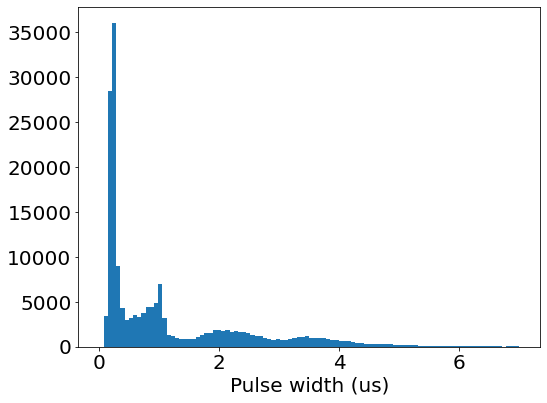

In [14]:
pl.figure()
pl.hist(cleanWidth*tscale, bins=100, range = (0, 7))
pl.xlabel("Pulse width (us)")
pl.show()

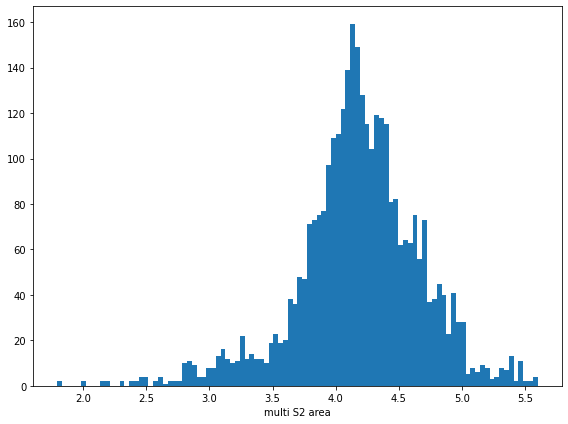

In [7]:
pl.figure()
pl.hist(np.log10(sum_s2_area[(drift_Time_AS>0)*(drift_Time<=0)]), bins=100)
pl.xlabel("multi S2 area")
pl.show()

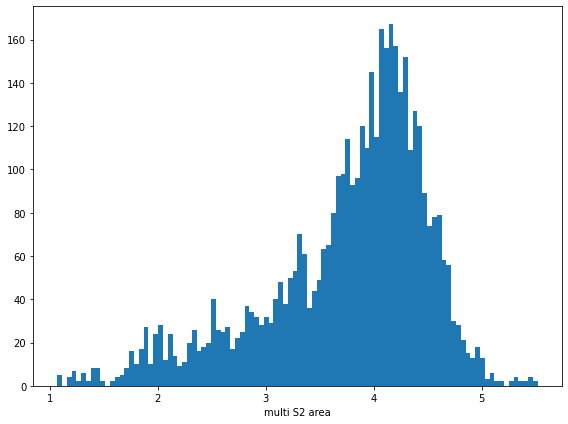

In [8]:
pl.figure()
pl.hist(np.log10(sum_s2_area[(drift_Time>0)]), bins=100)
pl.xlabel("multi S2 area")
pl.show()

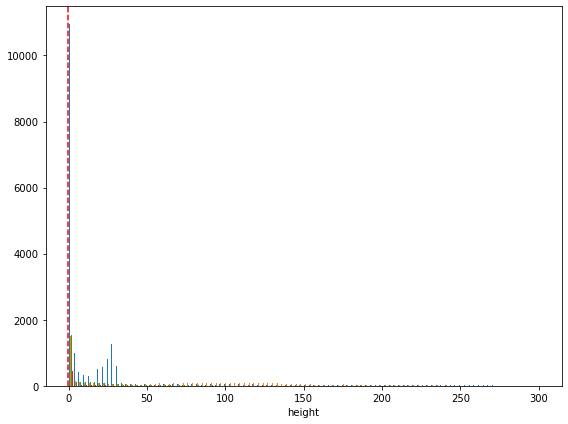

In [55]:
pl.figure()
pl.hist(p_max_height, bins=100, range = (0.01, 300))
pl.axvline(x=np.mean(cleanTBA), ls='--', color='r')
pl.xlabel("height")
pl.show()

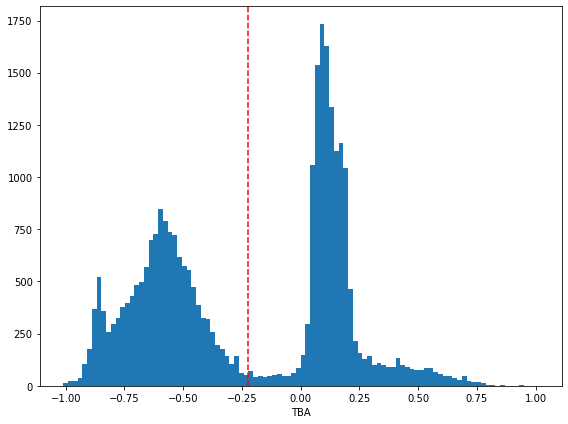

In [6]:
pl.figure()
pl.hist(cleanTBA, bins=100, range=(-1.01, 1.01))
pl.axvline(x=np.mean(cleanTBA), ls='--', color='r')
pl.xlabel("TBA")
if save_pulse_plots: pl.savefig(data_dir+"TBA_"+pulse_cut_name+".png")
#pl.show() 

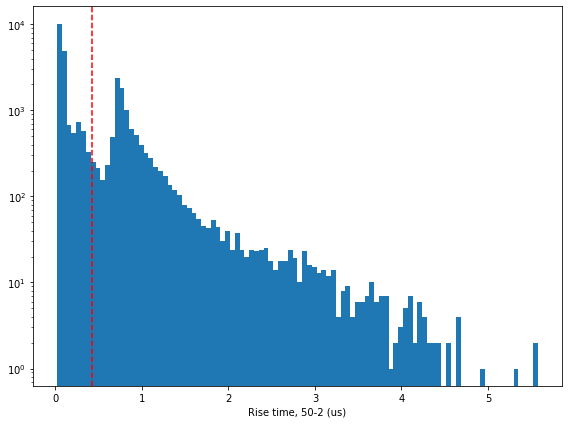

In [7]:
pl.figure()
pl.yscale("log")
pl.hist(cleanRiseTime, 100)
pl.axvline(x=np.mean(cleanRiseTime), ls='--', color='r')
pl.xlabel("Rise time, 50-2 (us)")
if save_pulse_plots: pl.savefig(data_dir+"RiseTime_"+pulse_cut_name+".png")
#pl.show()

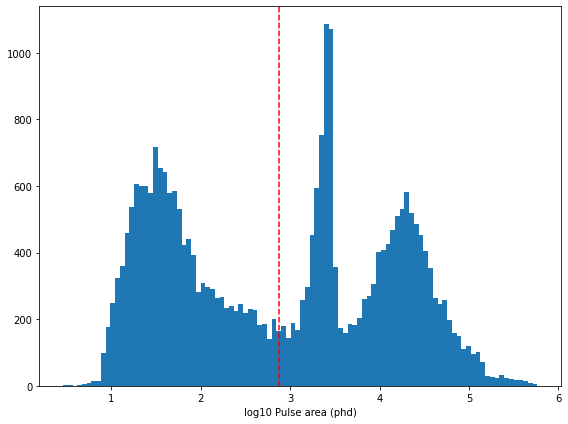

In [8]:
pl.figure()
#pl.yscale("log")
pl.hist(np.log10(cleanArea), 100)
pl.axvline(x=np.mean(np.log10(cleanArea)), ls='--', color='r')
pl.xlabel("log10 Pulse area (phd)")
if save_pulse_plots: pl.savefig(data_dir+"log10PulseArea_"+pulse_cut_name+".png")

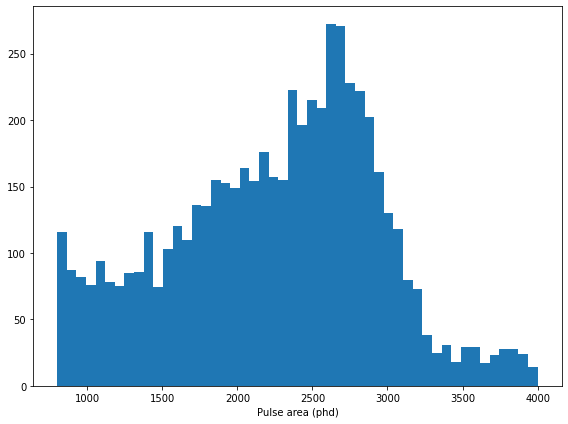

In [14]:
pl.figure()
#pl.yscale("log")
pl.hist(cleanArea, range = (800, 4000), bins = 50)
#pl.axvline(x=np.mean((cleanArea)), ls='--', color='r')
pl.xlabel("Pulse area (phd)")
if save_pulse_plots: pl.savefig(data_dir+"PulseArea_"+pulse_cut_name+".png")

In [ ]:
pl.figure()
#pl.yscale("log")
area_max_plot=150
pl.hist(cleanArea, bins=125,range=(0,area_max_plot))
if np.mean(cleanArea)<area_max_plot: pl.axvline(x=np.mean(cleanArea), ls='--', color='r')
pl.xlabel("Pulse area (phd)")
if save_pulse_plots: pl.savefig(data_dir+"PulseArea_Under150phd"+pulse_cut_name+".png")

In [ ]:
pl.figure()
pl.yscale("log")
pl.hist(cleanPulseClass )
pl.legend(handles=pc_legend_handles)
pl.xlabel("Pulse Class")
if save_pulse_plots: pl.savefig(data_dir+"PulseClass_"+pulse_cut_name+".png")

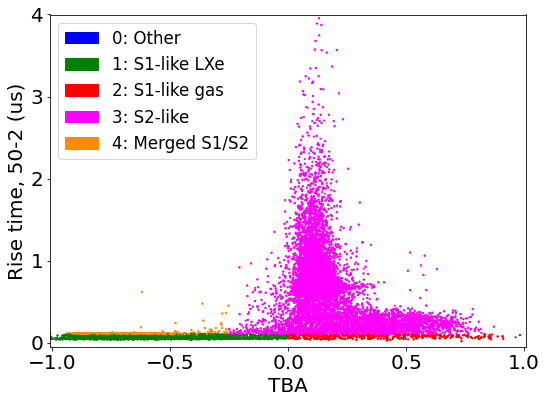

In [43]:
pl.figure()
pl.scatter(cleanTBA, cleanRiseTime, s = 1.2, c = pulse_class_colors[cleanPulseClass])
pl.xlim(-1.01,1.01)
pl.ylim(-0.05,4)
pl.ylabel("Rise time, 50-2 (us)")
pl.xlabel("TBA")
pl.legend(handles=pc_legend_handles)
if save_pulse_plots: pl.savefig(data_dir+"RiseTime_vs_TBA_"+pulse_cut_name+".png")

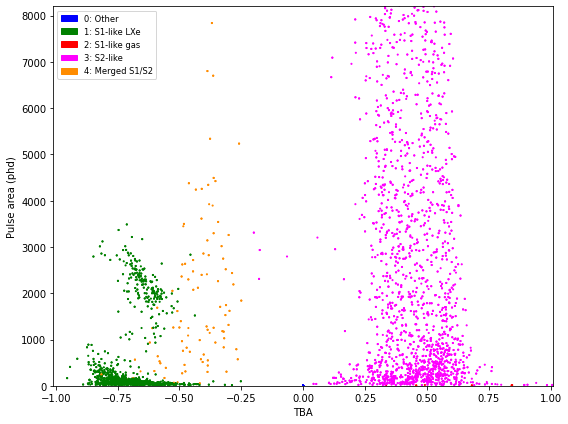

In [40]:
pl.figure()
pl.scatter(cleanTBA, cleanArea, s = 1.2, c = pulse_class_colors[cleanPulseClass])
pl.xlim(-1.01,1.01)
pl.ylim(0, 8200)
pl.ylabel("Pulse area (phd)")
pl.xlabel("TBA")
pl.legend(handles=pc_legend_handles)
if save_pulse_plots: pl.savefig(data_dir+"Pulse area_vs_TBA_"+pulse_cut_name+".png")

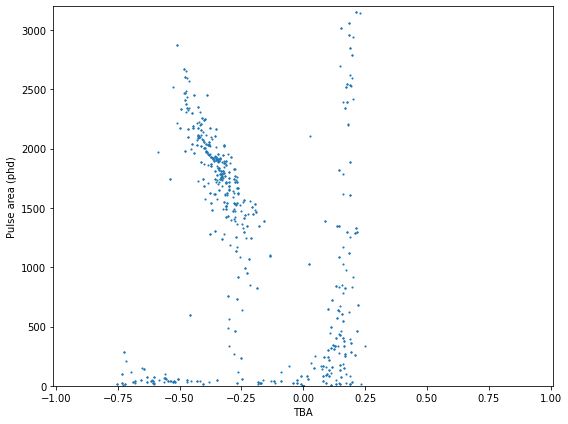

In [37]:
pl.figure()
pl.scatter(cleanTBA, cleanArea, s = 1.2)
pl.xlim(-1.01,1.01)
pl.ylim(0, 3200)
pl.ylabel("Pulse area (phd)")
pl.xlabel("TBA")
#pl.legend(handles=pc_legend_handles)
if save_pulse_plots: pl.savefig(data_dir+"Pulse area_vs_TBA_"+pulse_cut_name+".png")

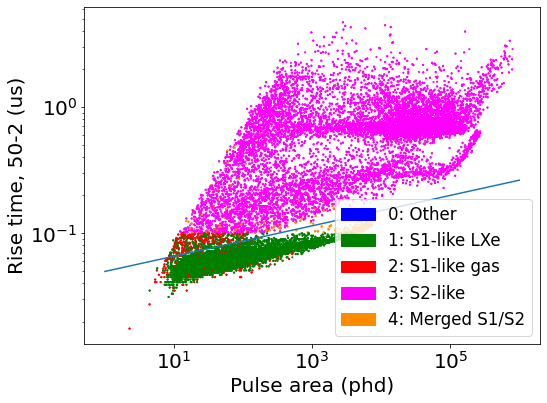

In [42]:
pl.figure()

x = np.linspace(1, 10**6, 10**4)
pl.xscale("log")
pl.yscale("log")
pl.scatter(cleanArea, cleanRiseTime, s = 1.2, c = pulse_class_colors[cleanPulseClass])
pl.plot(x, (1.5/100/np.log10(2))*(x**(np.log10(2)/2.5)))
pl.plot()
#pl.xlim(5,10**3)
#pl.ylim(0.03,0.5)
pl.ylabel("Rise time, 50-2 (us)")
pl.xlabel("Pulse area (phd)")
pl.legend(handles=pc_legend_handles, loc = 4)
#pl.xlim(0.7*min(p_area.flatten()), 1.5*max(p_area.flatten()))
#if save_pulse_plots: pl.savefig(data_dir+"RiseTime_vs_PulseArea_"+pulse_cut_name+".png")

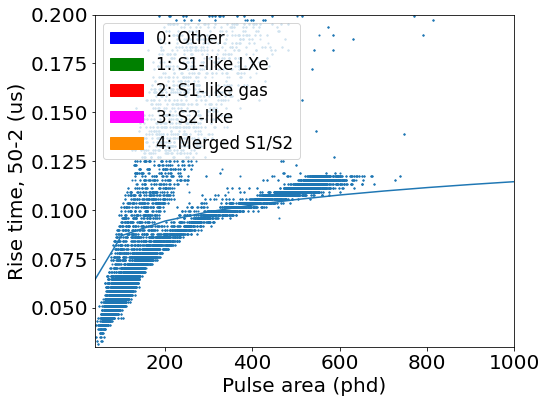

In [36]:
pl.figure()

x = np.linspace(1, 10**6, 10**4)
#pl.xscale("log")
#pl.yscale("log")
pl.scatter(cleanWidth, cleanRiseTime, s = 1.2)#, c = pulse_class_colors[cleanPulseClass])
pl.plot(x, (1.5/100/np.log10(2))*(x**(np.log10(2)/2.5)))
pl.plot()
pl.xlim(40,10**3)
pl.ylim(0.03,0.2)
pl.ylabel("Rise time, 50-2 (us)")
pl.xlabel("Pulse area (phd)")
pl.legend(handles=pc_legend_handles, loc = 2)
#pl.xlim(0.7*min(p_area.flatten()), 1.5*max(p_area.flatten()))
#if save_pulse_plots: pl.savefig(data_dir+"RiseTime_vs_PulseArea_"+pulse_cut_name+".png")

In [ ]:
# Channel fractional area for all pulses
pl.figure()
for j in range(0, n_channels-1):
    pl.subplot(4,2,j+1)
    pl.hist(cleanAreaChFrac[:,j],bins=100,range=(0,1))
    pl.axvline(x=np.mean(cleanAreaChFrac[:,j]), ls='--', color='r')
    #print("ch {0} area frac mean: {1}".format(j,np.mean(cleanAreaChFrac[:,j])))
    #pl.yscale('log')
    pl.xlabel("Pulse area fraction")
    pl.title('Ch '+str(j))
if save_pulse_plots: pl.savefig(data_dir+"pulse_ch_area_frac_"+pulse_cut_name+".png")

In [ ]:
# Plots of all S1 or all S2 pulses
pl.figure()
for j in range(0, n_channels-1):
    pl.subplot(4,2,j+1)
    pl.hist(cleanS1AreaChFrac[:,j],bins=100,range=(0,1))
    pl.axvline(x=np.mean(cleanS1AreaChFrac[:,j]), ls='--', color='r')
    #print("S1 ch {0} area frac mean: {1}".format(j,np.mean(cleanS1AreaChFrac[:,j])))
    #pl.yscale('log')
    pl.xlabel("S1 area fraction")
    pl.title('Ch '+str(j))
if save_S1S2_plots: pl.savefig(data_dir+"S1_ch_area_frac_"+pulse_cut_name+".png")

In [ ]:
pl.figure()
for j in range(0, n_channels-1):
    pl.subplot(4,2,j+1)
    pl.hist(cleanS2AreaChFrac[:,j],bins=100,range=(0,1))
    pl.axvline(x=np.mean(cleanS2AreaChFrac[:,j]), ls='--', color='r')
    #print("S2 ch {0} area frac mean: {1}".format(j,np.mean(cleanS2AreaChFrac[:,j])))
    #pl.yscale('log')
    pl.xlabel("S2 area fraction")
    pl.title('Ch '+str(j))
if save_S1S2_plots: pl.savefig(data_dir+"S2_ch_area_frac_"+pulse_cut_name+".png")

In [ ]:
pl.figure()
pl.hist(cleanS1TBA, bins=100, range=(-1.01,1.01) )
pl.axvline(x=np.mean(cleanS1TBA), ls='--', color='r')
pl.xlabel("S1 TBA")
if save_S1S2_plots: pl.savefig(data_dir+"S1TBA_"+pulse_cut_name+".png")

In [ ]:
pl.figure()
pl.hist(cleanS2TBA, bins=100, range=(-1.01,1.01) )
pl.axvline(x=np.mean(cleanS2TBA), ls='--', color='r')
pl.xlabel("S2 TBA")
if save_S1S2_plots: pl.savefig(data_dir+"S2TBA_"+pulse_cut_name+".png")

In [ ]:
pl.figure()
pl.hist(np.log10(cleanS1Area), 100)
pl.axvline(x=np.mean(np.log10(cleanS1Area)), ls='--', color='r')
pl.xlabel("log10 S1 area")
if save_S1S2_plots: pl.savefig(data_dir+"log10_S1_"+pulse_cut_name +".png")

In [ ]:
pl.figure()
pl.hist(np.log10(cleanS2Area), 100)
pl.axvline(x=np.mean(np.log10(cleanS2Area)), ls='--', color='r')
pl.xlabel("log10 S2 area")
if save_S1S2_plots: pl.savefig(data_dir+"log10_S2_"+pulse_cut_name +".png")

In [ ]:
pl.figure()
pl.hist(cleanS1Area, bins=125)
pl.axvline(x=np.mean(cleanS1Area), ls='--', color='r')
pl.xlabel("S1 area (phd)")
if save_S1S2_plots: pl.savefig(data_dir+"S1_"+pulse_cut_name +".png")

In [ ]:
pl.figure()
pl.hist(cleanS2Area, 500)
pl.axvline(x=np.mean(cleanS2Area), ls='--', color='r')
pl.xlabel("S2 area (phd)")
if save_S1S2_plots: pl.savefig(data_dir+"S2_"+pulse_cut_name +".png")

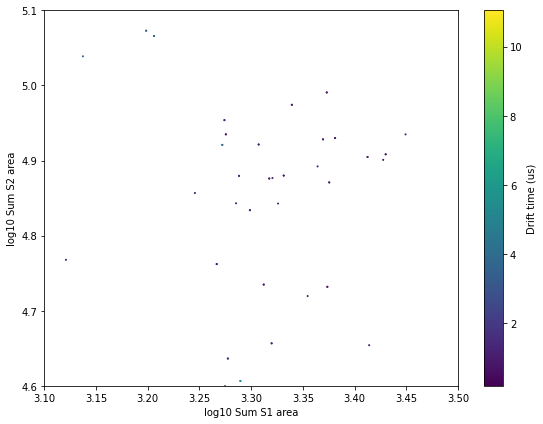

In [35]:
# Plots of event-level variables
pl.figure()
pl.scatter(np.log10(cleanSumS1), np.log10(cleanSumS2), s = 1, c=cleanDT)
pl.xlabel("log10 Sum S1 area")
pl.ylabel("log10 Sum S2 area")
pl.xlim(3.1, 3.5)
pl.ylim(4.6, 5.1)
cbar=pl.colorbar()
cbar.set_label("Drift time (us)")
if save_event_plots: pl.savefig(data_dir+"log10_SumS2_vs_log10_SumS1_"+event_cut_name +".png")

In [ ]:
pl.figure()
pl.hist(np.log10(cleanSumS1), 100)
pl.axvline(x=np.mean(np.log10(cleanSumS1)), ls='--', color='r')
pl.xlabel("log10 Sum S1 area (phd)")
if save_event_plots: pl.savefig(data_dir+"log10_SumS1_"+event_cut_name +".png")

<ipython-input-22-08e31cda5e83>:2: RuntimeWarning: divide by zero encountered in log10
  pl.hist(np.log10(cleanSumS2), 100)


ValueError: supplied range of [-inf, 5.235012273119975] is not finite

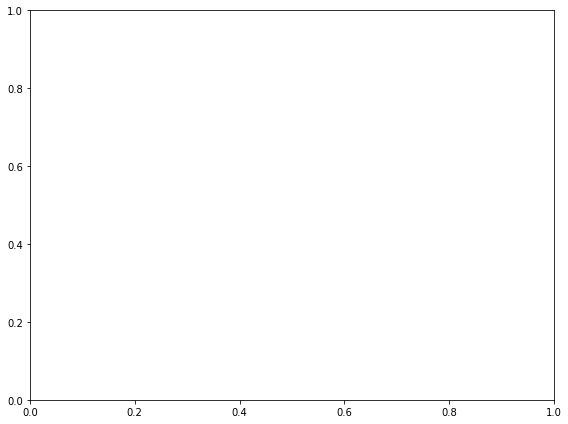

In [22]:
pl.figure()
pl.hist(np.log10(cleanSumS2), 100)
pl.axvline(x=np.mean(np.log10(cleanSumS2)), ls='--', color='r')
pl.xlabel("log10 Sum S2 area (phd)")
if save_event_plots: pl.savefig(data_dir+"log10_SumS2_"+event_cut_name +".png")

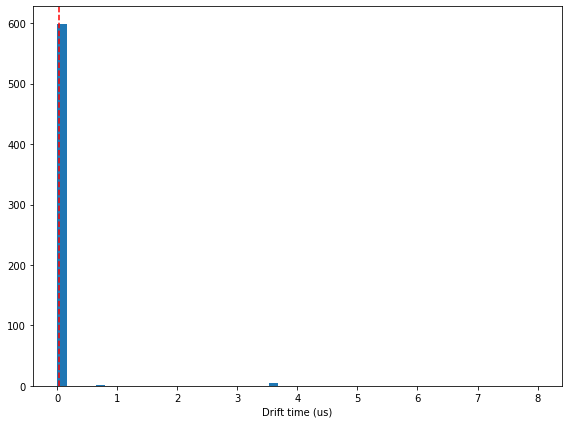

In [14]:
pl.figure() # Only ever plot this for SS events?
pl.hist(cleanDT, bins=50, range=(0,8))
pl.axvline(x=np.mean(cleanDT), ls='--', color='r')
pl.xlabel("Drift time (us)")
if save_event_plots: pl.savefig(data_dir+"DriftTime_"+event_cut_name +".png")

In [ ]:
pl.figure() # Only ever plot this for SS events?
pl.scatter(cleanDT, cleanSumS2)
pl.xlabel("Drift time (us)")
pl.ylabel("Sum S2 area")
# Calculate mean vs drift bin
drift_bins=np.linspace(0,13,50)
drift_ind=np.digitize(cleanDT, bins=drift_bins)
s2_medians=np.zeros(np.shape(drift_bins))
s2_std_err=np.ones(np.shape(drift_bins))*0#10000
for i_bin in range(len(drift_bins)):
    found_i_bin = np.where(drift_ind==i_bin)
    s2_area_i_bin = cleanSumS2[found_i_bin]
    if len(s2_area_i_bin) < 1: continue
    s2_medians[i_bin]=np.median(s2_area_i_bin) # Median instead of mean, better at ignoring outliers
    s2_std_err[i_bin]=np.std(s2_area_i_bin)/np.sqrt(len(s2_area_i_bin))
pl.errorbar(drift_bins, s2_medians, yerr=s2_std_err, linewidth=3, elinewidth=3, capsize=5, capthick=4, color='red')
pl.ylim(bottom=0)
if save_event_plots: pl.savefig(data_dir+"SumS2_vs_DriftTime_"+event_cut_name +".png")

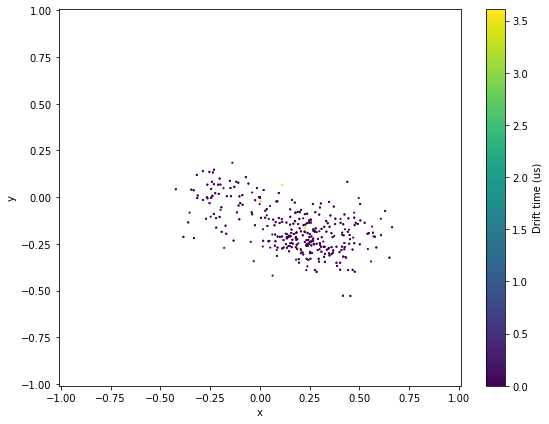

In [15]:
pl.figure()
pl.scatter(clean_center_top_x, clean_center_top_y, s = 1.2, c=clean_drift_time_four)
pl.xlim(-1.01,1.01)
pl.ylim(-1.01,1.01)
pl.ylabel("y")
pl.xlabel("x")
cbar=pl.colorbar()
cbar.set_label("Drift time (us)")
#pl.legend(handles=pc_legend_handles)
if save_pulse_plots: pl.savefig(data_dir+"Center of Mass on Top"+event_cut_name+".png")

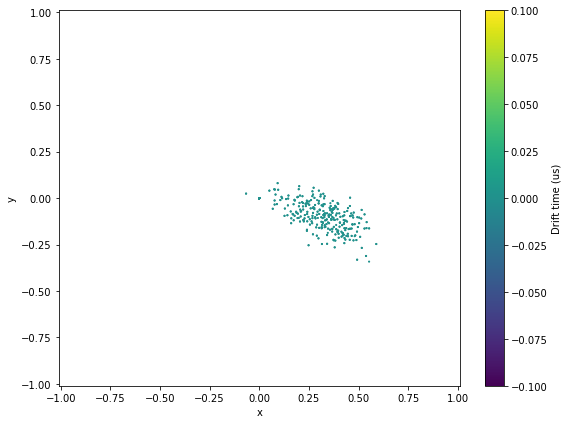

In [10]:
pl.figure()
pl.scatter(clean_center_bot_x, clean_center_bot_y, s = 1.2, c=clean_drift_time_four)
pl.xlim(-1.01,1.01)
pl.ylim(-1.01,1.01)
pl.ylabel("y")
pl.xlabel("x")
cbar=pl.colorbar()
cbar.set_label("Drift time (us)")
#pl.legend(handles=pc_legend_handles)
if save_pulse_plots: pl.savefig(data_dir+"Center of Mass bottom"+event_cut_name+".png")

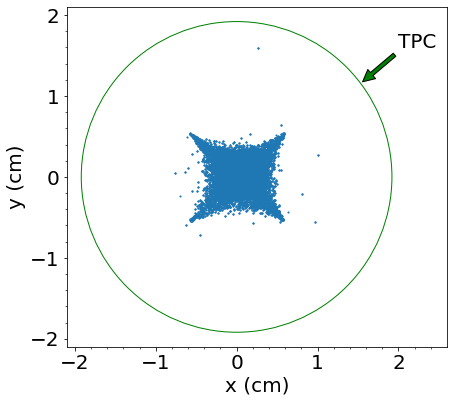

In [84]:
fig = pl.figure()
ax = fig.add_subplot(1, 1, 1)

d_between_SiPM_center_x = 1.23
d_between_SiPM_center_y = 1.14
TPC_diameter = 3.84 # in cm
clean_center_bot_x_d = clean_center_bot_x * d_between_SiPM_center_x/2
clean_center_bot_y_d = clean_center_bot_y * d_between_SiPM_center_y/2
circ = pl.Circle((0,0), radius=TPC_diameter/2, color='g', fill = False)
pl.scatter(clean_center_bot_x_d, clean_center_bot_y_d, s = 1.2)
pl.xlim(-2.1,2.6)
pl.ylim(-2.1,2.1)
pl.ylabel("y (cm)")
pl.xlabel("x (cm)")
pl.minorticks_on()
ax.add_patch(circ)
ax.set_aspect('equal', adjustable='box')
ax.annotate('TPC', xy =(TPC_diameter/2*np.cos(np.pi*37/180), TPC_diameter/2*np.sin(np.pi*37/180)),
                xytext =(2, 1.6), 
                arrowprops = dict(facecolor ='green',
                                  shrink = 0.05),)
#pl.legend(handles=pc_legend_handles)
if save_pulse_plots: pl.savefig(data_dir+"Center of Mass bottom tpc(no drift time)"+pulse_cut_name+".png")

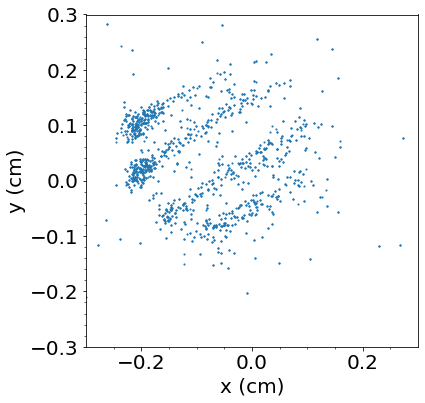

In [76]:
fig = pl.figure()
ax = fig.add_subplot(1, 1, 1)

pl.scatter(clean_center_bot_x_d, clean_center_bot_y_d, s = 1.2)
pl.xlim(-.3,.3)
pl.ylim(-.3,.3)
pl.ylabel("y (cm)")
pl.xlabel("x (cm)")
pl.minorticks_on()
ax.set_aspect('equal', adjustable='box')

#pl.legend(handles=pc_legend_handles)
if save_pulse_plots: pl.savefig(data_dir+"Center of Mass bottom (no drift time)"+pulse_cut_name+".png")

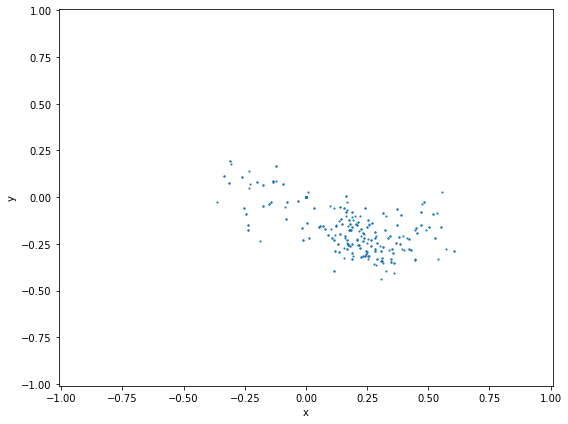

In [31]:
pl.figure()
pl.scatter(clean_center_top_x, clean_center_top_y, s = 1.2)
pl.xlim(-1.01,1.01)
pl.ylim(-1.01,1.01)
pl.ylabel("y")
pl.xlabel("x")
#pl.legend(handles=pc_legend_handles)
if save_pulse_plots: pl.savefig(data_dir+"Center of Mass on Top (no drift time) "+event_cut_name+".png")